Active region open field
------------
This notebook calculates the active region open field regions.

In [1]:
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
import astropy.units as u

import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
import matplotlib.patches as mpatch
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec

import numpy as np
import sunpy.map
from sunpy.coordinates import HeliographicCarrington
from sunpy.time import parse_time

import pfsspy
from pfsspy import coords
from pfsspy import tracing

import solar_library
from helpers import figdir
from pubtools import solar as solartools

Set the parameters for each active region
----
``nar`` can be set to 1 or 2 to run analysis for each active region in turn.

In [2]:
nar = 2

data = {2: {'gong_map': 'data/mrzqs130116t1324c2132_062.fits.gz',
            'hmi_time': '2013/01/16 12:00:00',
            'ar_long': 120 * u.deg,
            'scale': 0.1,
            'cutoff': lambda x :(x.Ty < 300 * u.arcsec) & (x.Tx > 200 * u.arcsec),
            'eis_map': 'data/ARs/total_map.fits',
            'dop_map': 'data/ARs/total_map_doppler.fits'},
        1: {'gong_map': 'data/mrzqs080110t2354c2065_130.fits.gz',
            'hmi_time': '2008/01/10 22:51:00',
            'ar_long': 181 * u.deg,
            'scale': -0.1,
            'cutoff': lambda x : (x.Ty > -75 * u.arcsec) & (x.Tx > 0 * u.arcsec),
            'eis_map': 'data/ARs/artemp_20080110.fits',
            'dop_map': 'data/ARs/doppler_20080110.fits'}
        }

data = data[nar]

Get tracing seeds
---

In [3]:
# Load synoptic magnetic field map
synoptic_map = solar_library.get_gong_map(data['gong_map'])
shape = [300, 300]
# Create header for array of tracing seeds
header = sunpy.map.make_fitswcs_header(shape,
                                       coordinate=SkyCoord(data['ar_long'], 0 * u.deg,
                                                           frame=synoptic_map.coordinate_frame),
                                       reference_pixel=[0, 0] * u.pix,
                                       scale=[0.1, data['scale']] * u.deg / u.pix,
                                       projection_code='CAR')
# Populate the map with zeroes, so we can calculate all the coordiantes to take as seeds
fake_map = sunpy.map.Map(np.zeros(shape), header)
seeds = sunpy.map.all_coordinates_from_map(fake_map)

Plot the tracing region
---

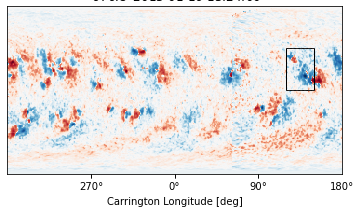

In [4]:
synoptic_map.plot(cmap='RdBu', norm=mcolor.SymLogNorm(linthresh=10, base=10))
ax = plt.gca()
synoptic_map.draw_rectangle(bottom_left=fake_map.bottom_left_coord,
                            top_right=fake_map.top_right_coord,
                            color='black');

Calculate PFSS solution
---

In [8]:
nrho = 60
rss = 2.5

pfss_input = pfsspy.Input(synoptic_map, nrho, rss)
pfss_output = pfsspy.pfss(pfss_input)

Trace field lines
---

In [6]:
tracer = tracing.FortranTracer(1000, 0.01)
field_lines = tracer.trace(seeds.ravel(), pfss_output)

/Users/dstansby/miniconda3/envs/pub-env/lib/python3.8/site-packages/streamtracer/streamline.py:223: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  xs_f = np.array([xi[:ni, :] for xi, ni in zip(xs_f, ns_f)])
/Users/dstansby/miniconda3/envs/pub-env/lib/python3.8/site-packages/streamtracer/streamline.py:224: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  xs_r = np.array([xi[ni - 1:0:-1, :] for xi, ni in zip(xs_r, ns_r)])
/Users/dstansby/miniconda3/envs/pub-env/lib/python3.8/site-packages/streamtracer/streamline.py:227: VisibleDeprecationWarning: Creating an

Create a WCS for the traced polarities
---

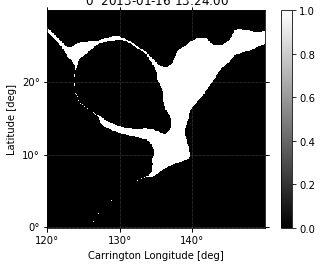

In [7]:
pols = field_lines.polarities.reshape(seeds.shape)
pols = sunpy.map.Map(pols, header)
pols.peek()

Contour polarities on top of GONG map
---

<ipython-input-82-de3bd18b4509>:5: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  map_in.plot(ax, norm=mcolor.SymLogNorm(linthresh=10))
/Users/dstansby/miniconda3/envs/pub-env/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


(0.0, 180.0)

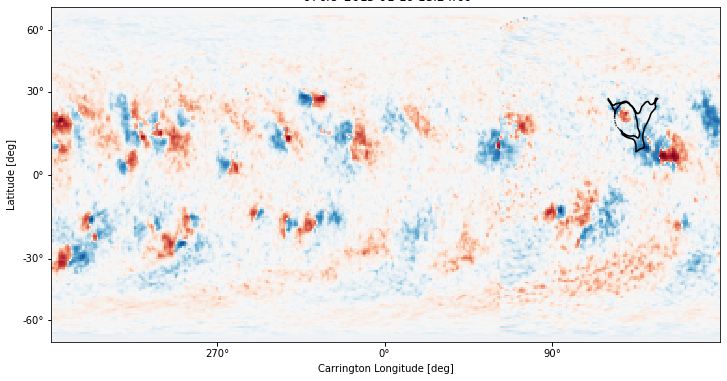

In [82]:
map_in = pfss_input.map
# Plot result
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=map_in)
map_in.plot(ax, norm=mcolor.SymLogNorm(linthresh=10))

ax.contour(pols.data, transform=ax.get_transform(pols.wcs), levels=[0.5,], colors=['k'], linestyles='solid')
    
ax.set_xlim(0, 360)
ax.set_ylim(0, 180)

Import LOS magnetogram
---

In [12]:
hmi_map = solar_library.get_AR_HMI_map(data['hmi_time'])
hmi_map = solartools.cos_theta_correction(hmi_map)

Export request pending. [id="JSOC_20200908_159", status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 2MB


Transform contour to HMI frame
---

In [14]:
pols.meta['date-obs'] = hmi_map.meta['date-obs']
# Get the polarity contour
c = solartools.contour(pols, 0.5)[0]
# Transform to HMI frame
c_hmi = c.transform_to(hmi_map.coordinate_frame)
c_hmi = c_hmi[data['cutoff'](c_hmi)]

Calculate average magnetic field inside mask
---

In [27]:
areas = solartools.deprojected_areas(hmi_map)
ar_mask = solartools.contour_to_mask(c_hmi, hmi_map)
flux = np.nansum(hmi_map.data[ar_mask.T] * u.gauss * areas[ar_mask.T]) 
B = flux / np.nansum(areas[ar_mask.T])
B.to(u.G)

<Quantity 18.44971509 G>

Plot HMI map
---

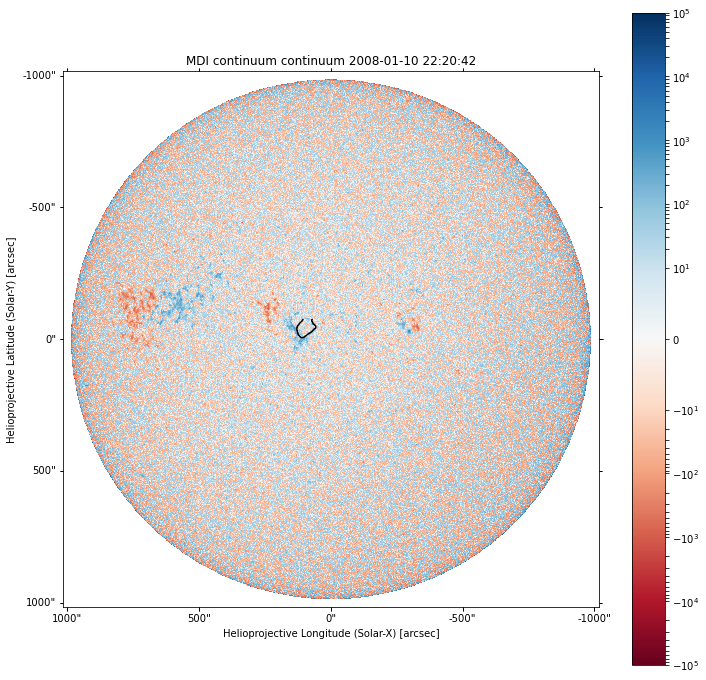

In [28]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection=hmi_map)
hmi_map.plot(cmap='RdBu', norm=mcolor.SymLogNorm(linthresh=10, base=10, vmin=-1e5, vmax=1e5))
#.imshow(ar_mask, alpha=0.5)
ax.plot_coord(c_hmi, color='k')
plt.colorbar()

Save countour to file
---

In [85]:
temp_map = sunpy.map.Map(data[var])
temp_map.meta['date-obs'] = pols.meta['date-obs']
temp_map.meta.pop('mjd-obs', None)
c = solartools.contour(pols, 0.5)[0]
# Transform to HMI frame
c_eis =  c.transform_to(temp_map.coordinate_frame)
c_eis = c_eis[data['cutoff'](c_eis)]
c_eis = concatenate((c_eis, c_eis[0]))
c_npy = np.column_stack((c_eis.Tx.to_value(u.arcsec), c_eis.Ty.to_value(u.arcsec)))
np.savetxt(f'Data/open_field_contour_{nar}.txt', c_npy)